### With frustrations abounding regarding the ppar intensity in and out of the cebp blobs I am going to look at an individual image a little closer

In [299]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, measure, exposure, morphology
from scipy.ndimage.filters import gaussian_laplace
from skimage.filters import gaussian
from scipy import ndimage as ndi
from skimage.feature import blob_dog, blob_log, blob_doh


In [300]:
ppar_palette = sns.color_palette('PuRd', 20)
cebp_palette = sns.color_palette('YlGn', 20)
dapi_palette = sns.color_palette('Blues', 20)
area_palette = sns.color_palette('Greys', 20)

In [288]:
os.chdir(r'Z:\TAD\200428_adipogenesis_timecourses_revisited\190718_3t3l1_time_course_r5\stad3-42-xy3_cebp_segm_cell7_blob_testing')

In [301]:
plt.style.use('dark_background')

In [304]:
cebp_n_blob = io.imread('cabp_n_blob.tif')
cebp_blob = io.imread('cebp_blob.tif')
cebp_nucleus = io.imread('cebp_nucleus.tif')
cebp_orig = io.imread('cebp_orig.tif')
dapi_blob = io.imread('dapi_blob.tif')
dapi_nucleus = io.imread('dapi_nucleus.tif')
dapi_n_blob = io.imread('dapi_n_blob.tif')
dapi_orig = io.imread('dapi_orig.tif')
mask_blob = io.imread('mask_blob.tif')
mask_nucleus = io.imread('mask_nucleus.tif')
mask_n_blob = io.imread('mask_n_blob.tif')
ppar_blob = io.imread('ppar_blob.tif')
ppar_nucleus = io.imread('ppar_nucleus.tif')
ppar_n_blob = io.imread('ppar_n_blob.tif')
ppar_orig = io.imread('ppar_orig.tif')

In [314]:
ppar_n_blob_flat = ppar_n_blob.flatten()
ppar_n_blob_flat = ppar_n_blob_flat[ppar_n_blob_flat > 0]
binner = np.linspace(1, 10000, 100)
ax = sns.distplot(ppar_n_blob_flat, bins = binner, color = ppar_palette[12])

ppar_blob_flat = ppar_blob.flatten()
ppar_blob_flat = ppar_blob_flat[ppar_blob_flat > 0]
ax = sns.distplot(ppar_blob_flat, bins = binner, color = area_palette[1])

plt.legend(['ppar out of blobs', 'ppar in blobs'])

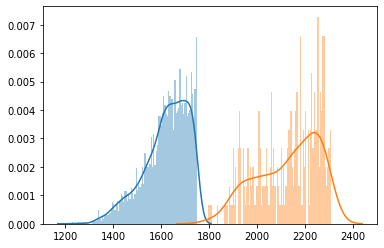

In [33]:
ppar_n_blob_bq = ppar_n_blob_flat[ppar_n_blob_flat < np.quantile(ppar_n_blob_flat, .1)]
ppar_blob_bq = ppar_blob_flat[ppar_blob_flat < np.quantile(ppar_blob_flat, .1)]

ax = sns.distplot(ppar_n_blob_bq, bins = 100)
ax = sns.distplot(ppar_blob_bq, bins = 100)

In [109]:
ppar_normed = ppar_nucleus / np.max(ppar_nucleus)


In [110]:
def dot_2d(struct_img, s2_param):
    bw = np.zeros(struct_img.shape, dtype=bool)
    for fid in range(len(s2_param)):
        log_sigma = s2_param[fid][0]
        responce = np.zeros_like(struct_img)
        responce = -1*(log_sigma**2)*ndi.filters.gaussian_laplace(struct_img, log_sigma)
        bw = np.logical_or(bw, responce>s2_param[fid][1])
    return bw

In [114]:
%matplotlib qt

In [118]:
ppar_dots = dot_2d(ppar_normed, [[.6, .03]])

fig, axes = plt.subplots(1,2)
axes = axes.flatten()

axes[0].imshow(ppar_normed)
axes[1].imshow(ppar_dots)


In [177]:
ppar_blob = blob_log(ppar_normed, max_sigma=3, num_sigma=1, threshold=.05)

In [178]:
ppar_blob.shape

(61, 3)

In [270]:
y = ppar_blob[:, 0]
x = ppar_blob[:, 1]
r = ppar_blob[:, 2]

r

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [283]:
fig, ax = plt.subplots()
#ax = axes.ravel()


for idx in [0]:
    ax.imshow(exposure.rescale_intensity(ppar_nucleus))
    ax.scatter(ringx, ringy, color = 'y', s = .15)
    for blob in ppar_blob:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='r', linewidth=1, fill=False)
        ax.add_patch(c)
    ax.set_axis_off()

In [257]:
blob_erosion = morphology.binary_erosion(mask_blob, morphology.disk(1))
cebp_ring = np.subtract(mask_blob, blob_erosion)

In [259]:
cebp_ring_ = np.multiply(1, cebp_ring)

ax = plt.imshow(ppar_nucleus)
ax = plt.scatter(ringx, ringy, color = 'r', marker = ',', s= .15)

In [281]:
ringy = np.argwhere(cebp_ring == 1)[:, 0]
ringx = np.argwhere(cebp_ring == 1)[:, 1]

#ringy = ringy[::2]
#ringx = ringx[::2]

In [236]:
ringx

array([ 11,  11,  11, ..., 154, 155, 155], dtype=int64)

### just for shits and giggles I will do a quick analysis on this

In [264]:
blob_x = np.argwhere(mask_blob == 1)[:, 1]
blob_y = np.argwhere(mask_blob == 1)[:, 0]

In [271]:
ppar_x = x.copy()
ppar_y = y.copy()

In [277]:
point_distances = []


for x_p, y_p in zip(ppar_x * .065, ppar_y * .065):
    min_dist = 1000
    for x_c, y_c in zip(blob_x * .065, blob_y * .065):
        dist_ = np.sqrt((x_p - x_c) **2 + (y_p - y_c) ** 2)
        min_dist = np.min([min_dist, dist_])
    point_distances.append(min_dist)

In [280]:
plt.hist(point_distances)

(array([17., 15., 15.,  7.,  1.,  3.,  1.,  0.,  1.,  1.]),
 array([0.        , 0.26744953, 0.53489906, 0.80234858, 1.06979811,
        1.33724764, 1.60469717, 1.8721467 , 2.13959622, 2.40704575,
        2.67449528]),
 <a list of 10 Patch objects>)

In [269]:
x

198.0